# Imbalanced Dataset 

In [1]:
# Class imbalance
# Weighting of errors
# How to compare the classifiers
# Dimensionality reduction techniques

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import matplotlib.lines as lines
import matplotlib.colors as colors

import scipy.stats 

import math
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
import sklearn.naive_bayes
import sklearn.linear_model

import sklearn.datasets

from dataclasses import dataclass
from typing import Tuple

from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

import sklearn.metrics

RESOLUTION = 100
MINX, MAXX = -7, 7
MINY, MAXY = -7, 7

cmap = 'jet'

def show_cls(ax, cls):
    ax.set_xlim([MINX, MAXX])
    ax.set_ylim([MINY, MAXY])
    
    xspace = np.linspace(MINX, MAXX, RESOLUTION)
    yspace = np.linspace(MINY, MAXY, RESOLUTION)
    xmesh, ymesh = np.meshgrid(xspace, yspace)
    
    xytest = np.vstack([np.ravel(xmesh), np.ravel(ymesh)]).T
    predicted_classes = cls.predict(xytest)
    
    ax.contourf(xspace, yspace, predicted_classes.reshape(xmesh.shape)
                , cmap=cmap, alpha=0.3, vmin=0, vmax=1)

In [2]:
# create dataset
# a) binary
# b) 'clear' class - abundant
#    'malicious' class - rare
np.random.seed(0)

N0 = 100
N1 = 7

Xtest, Ytest = sklearn.datasets.make_blobs(
    n_samples=10000,
    cluster_std=[1.0, 2.5],
    centers=2,
)

X, Y = sklearn.datasets.make_blobs(
    n_samples=max(N0, N1) * 2,
    cluster_std=[1.0, 2.5],
    random_state=0,
    centers=2,
    shuffle=True,
)
Y = np.abs(1 - Y)
Ytest = np.abs(1 - Ytest)

i = np.vstack([np.argwhere(Y==0)[:N0], np.argwhere(Y==1)[:N1]]).ravel()
X = X[i]
Y = Y[i]

## Naive Approach - Do Nothing
Classifiers predictions frequently correspond the distribution in the data. 
Moreover, if one class is much more prevalent than others, the classifier may not predict anything else. 

Therefore, if we use the classifier out of the box, we automatically make two assumptions (depending on the implementation):
- The a priori class probability is the same for training dataset and test dataset.
- The cost of mistake is same for all types of errors.

In the example below, a Logistic Regression predicts mostly one class (picture 3.).

## Setting a priori probability of class to be balanced
When setting "class_weight='balanced'", the prior probability of classes is excepted to be  p(0) = 0.5, p(1) = 0.5. 
Now there are two assumptions:
- the probabilities of all classes are the same
- the cost of misclassification is the same for all types of errors (False Negative, False Positive)

Text(-3.0, -3.0, 'People')

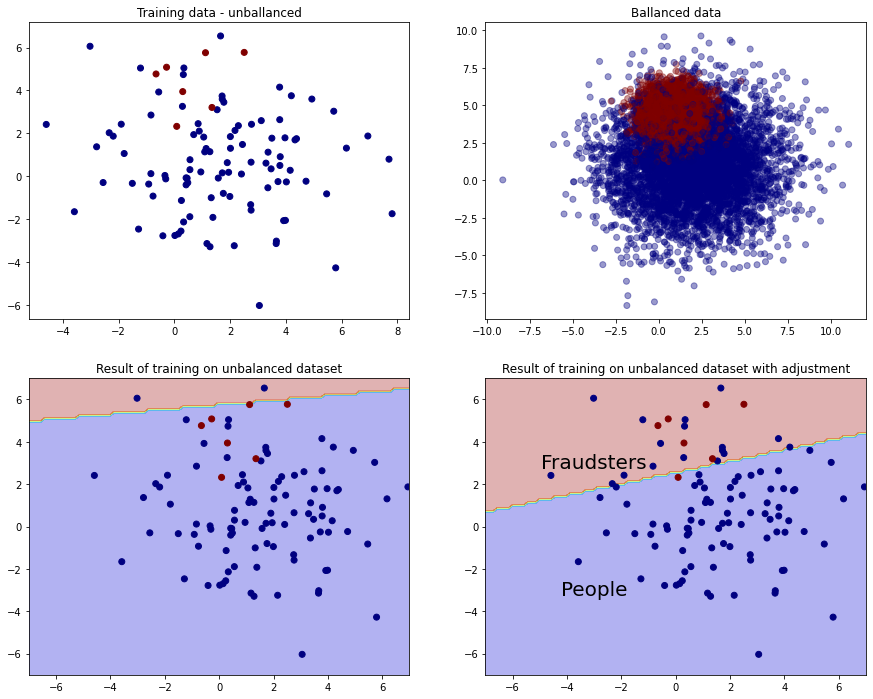

In [3]:
fig, axs = plt.subplots(2,2, figsize=(15,12))
# 0
axs[0][0].scatter(*X.T, c=Y, cmap='jet')
axs[0][0].set_title('Training data - unballanced')

# 1
axs[0][1].scatter(*Xtest.T, c=Ytest, alpha=0.4, cmap=cmap)
axs[0][1].set_title('Ballanced data')

# 2
model = LogisticRegression().fit(X,Y)
show_cls(axs[1][0], model)
axs[1][0].scatter(*X.T, c=Y, cmap=cmap)
axs[1][0].set_title('Result of training on unbalanced dataset')

# 3
model = LogisticRegression(class_weight='balanced').fit(X, Y)
show_cls(axs[1][1], model)
axs[1][1].scatter(*X.T, c=Y, cmap=cmap)
axs[1][1].set_title('Result of training on unbalanced dataset with adjustment')

axs[1][1].text(-3.0, 3.0, 'Fraudsters', fontsize=20, va='center', ha='center')
axs[1][1].text(-3.0,-3.0, 'People', fontsize=20, va='center', ha='center')

In [4]:
def test_model_on_different_prior(model, prior1, cost_matrix=None):
    if cost_matrix is None:
        cost_matrix = np.array([[0, 1],[1, 0]])
        
    Ypred = model.predict(Xtest)
    i0 = Ytest == 0
    i1 = Ytest == 1
    
    e0 = np.mean(cost_matrix[Ypred[i0], 0])
    e1 = np.mean(cost_matrix[Ypred[i1], 1])
    #return (e0 + e1) / (len(i0) + len(i1))
    return e0*(1-prior1) + e1*prior1

## Models based on probability 
The priors can be explicitly set for some models.

Text(0.5, 1.0, 'Changing a priori probability for LDA')

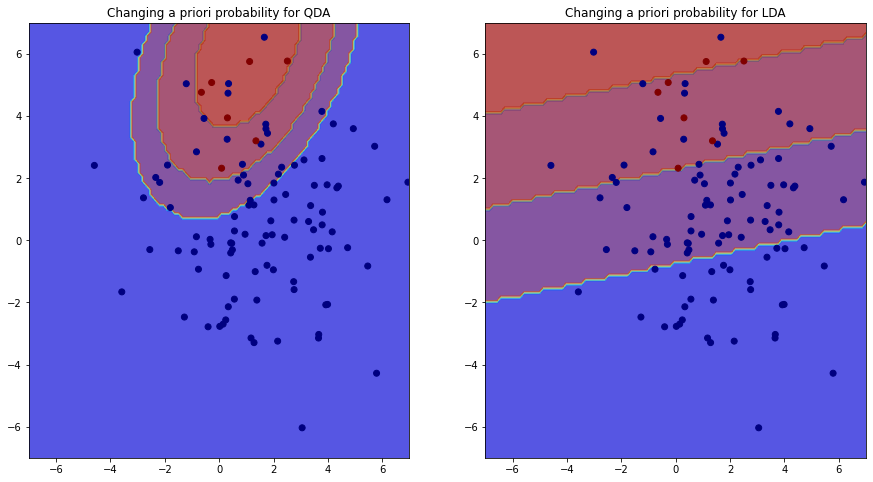

In [5]:
fig, axs = plt.subplots(1,2, figsize=(15,8))

for prior in [0.1, 0.5, 0.9]:
    model = QuadraticDiscriminantAnalysis(priors=[1-prior, prior]).fit(X, Y)
    show_cls(axs[0], model)
    model = LinearDiscriminantAnalysis(priors=[1-prior, prior]).fit(X, Y)
    show_cls(axs[1], model)

axs[0].scatter(*X.T, c=Y, cmap=cmap)
axs[1].scatter(*X.T, c=Y, cmap=cmap)
axs[0].set_title("Changing a priori probability for QDA") 
axs[1].set_title("Changing a priori probability for LDA") 

Correct models have the best performance when provided priors match the true priors.

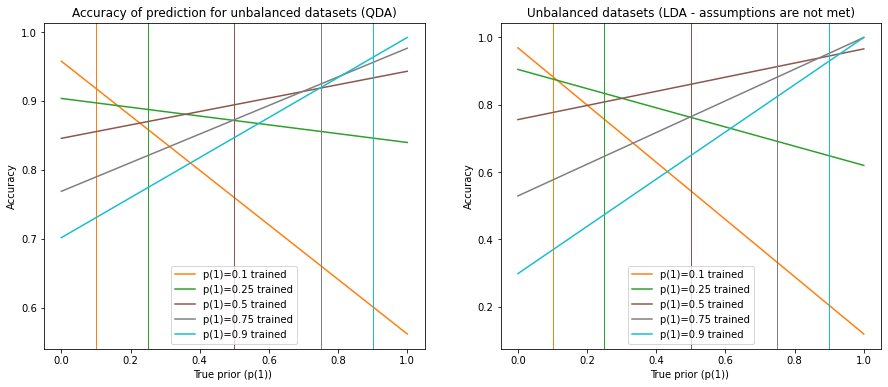

In [6]:
fig, axs = plt.subplots(1,2, figsize=(15,6))
true_priors = np.linspace(0, 1, 200)

priors = [0.1, 0.25, 0.5, 0.75, 0.9]
colors = matplotlib.colormaps['tab10'](priors)

for prior, color in zip(priors, colors):
    model = QuadraticDiscriminantAnalysis(priors=[1-prior, prior]).fit(X, Y)
    acc = np.array(list(map(
        lambda p: 1 - test_model_on_different_prior(model, p)
        , true_priors)))

    axs[0].plot(true_priors, acc, label=f"p(1)={prior} trained", color=color)
    axs[0].legend()
    
    axs[0].axvline(prior, lw=1, color=color)
    axs[0].set_title('Accuracy of prediction for unbalanced datasets (QDA)')
    axs[0].set_xlabel('True prior (p(1)) ')
    axs[0].set_ylabel('Accuracy')
    
    model = LinearDiscriminantAnalysis(priors=[1-prior, prior]).fit(X, Y)
    acc = np.array(list(map(
        lambda p: 1 - test_model_on_different_prior(model, p)
        , true_priors)))

    axs[1].plot(true_priors, acc, label=f"p(1)={prior} trained", color=color)
    axs[1].legend()
    
    axs[1].axvline(prior, lw=1, color=color)
    axs[1].set_title('Unbalanced datasets (LDA - assumptions are not met)')
    axs[1].set_xlabel('True prior (p(1)) ')
    axs[1].set_ylabel('Accuracy')

## Weighted models
Sometimes, weights of samples are accepted instead of the priors.
Thus, in balanced model, every sample of the class $x$ generates loss weighted by

$$
\text{Weight}_\text{balanced} = \frac{N}{N_x}
$$
In this way, the expected sum of unknown internal errors is proportional to
$$
    \underbrace{\frac{N_0 + N_1}{N_0} E_0 N_0}_{\text{Sum of errors of class 0}} = 
    \underbrace{\frac{N_0 + N_1}{N_1} E_1 N_1}_{\text{Sum of errors of class 1}} = 
    (N_0 + N_1) E = N E
$$
In similar manner, the preference of one class over the other can be scaled by prior probability to achieve similar class preference to the aforementioned probability based models
$$
\text{Weight}_\text{simulate_probability} = \frac{N}{N_x} P_x 
$$

Text(0.5, 1.0, 'Changing weights of samples for Logistic Regression')

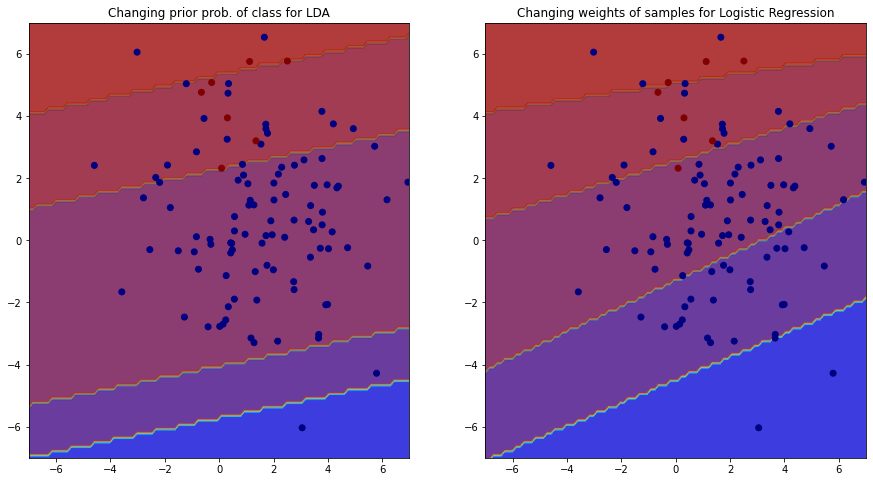

In [7]:
fig, axs = plt.subplots(1,2, figsize=(15,8))

# draw
for weight in [0.1, 0.5, 0.99, 0.997]:
    weight0 = (N1+N0)/(N0) * (1 - weight)
    weight1 = (N1+N0)/(N1) * weight
    model = LogisticRegression(class_weight={0:weight0, 1:weight1}).fit(X, Y)

    show_cls(axs[1], model)
    
    prior = weight
    model = LinearDiscriminantAnalysis(priors=[1-prior, prior]).fit(X, Y)
    show_cls(axs[0], model)
    
axs[0].scatter(*X.T, c=Y, cmap=cmap)
axs[1].scatter(*X.T, c=Y, cmap=cmap)

axs[0].set_title("Changing prior prob. of class for LDA") 
axs[1].set_title("Changing weights of samples for Logistic Regression") 

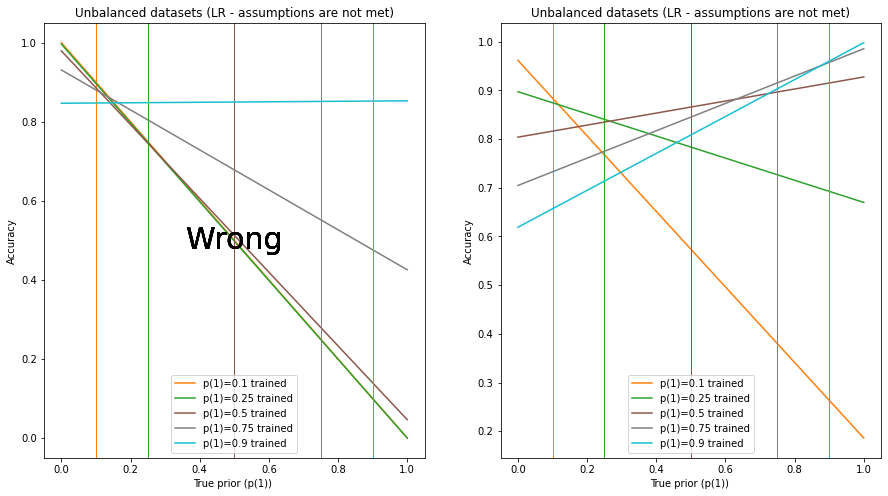

In [8]:
fig, axs = plt.subplots(1,2, figsize=(15,8))

for t in [0, 1]:
    for prior, color in zip(priors, colors):
        if t == 0:
            weight0 = 1-prior 
            weight1 = prior
            axs[t].text(0.5, 0.5, 'Wrong', fontsize=30, va='center', ha='center')
        elif t == 1:
            weight0 = (N1+N0)/(N0) * (1-prior)
            weight1 = (N1+N0)/(N1) * prior

        model = LogisticRegression(class_weight={0:weight0, 1:weight1}).fit(X, Y)
        acc = np.array(list(map(
            lambda p: 1 - test_model_on_different_prior(model, p)
            , true_priors)))

        axs[t].plot(true_priors, acc, label=f"p(1)={prior} trained", color=color)
        axs[t].legend()

        axs[t].axvline(prior, lw=1, color=color)
        axs[t].set_title('Unbalanced datasets (LR - assumptions are not met)')
        axs[t].set_xlabel('True prior (p(1)) ')
        axs[t].set_ylabel('Accuracy')

## Resampling strategies 
### Undersampling
Remove samples of the major class.

In [9]:
X_res, Y_res = RandomUnderSampler(random_state=0).fit_resample(X, Y)

print(f"classes: {Counter(Y_res)}")
print('Contents:')
for x, y in  Counter(map(tuple, X_res[Y_res == 1])).items():
    print(f"{y}x\t{x}")
    
model = LogisticRegression( ).fit(X, Y)
model_bal = LogisticRegression(class_weight='balanced').fit(X, Y)
model_res = LogisticRegression( ).fit(X_res, Y_res)

print()
print(f"acc. naive       :\t{sklearn.metrics.accuracy_score(Ytest, model.predict(Xtest))}")
print(f"acc. balanced    :\t{sklearn.metrics.accuracy_score(Ytest, model_bal.predict(Xtest))}")
print(f"acc. undersample :\t{sklearn.metrics.accuracy_score(Ytest, model_res.predict(Xtest))}")

classes: Counter({0: 7, 1: 7})
Contents:
1x	(2.509049292904953, 5.7731460973486755)
1x	(0.303809630770544, 3.9442341659078486)
1x	(1.1203136497073731, 5.758060834411365)
1x	(0.0884843309163823, 2.322990859224463)
1x	(-0.6539282684195495, 4.7665695829741646)
1x	(1.3526956097021245, 3.2043865368641953)
1x	(-0.27652528150343114, 5.0812776832803)

acc. naive       :	0.5197
acc. balanced    :	0.8656
acc. undersample :	0.8101


### Oversampling
Duplicate samples of the minor class.

In [10]:
X_res, Y_res = RandomOverSampler(random_state=0).fit_resample(X, Y)
print(f"classes: {Counter(Y_res)}")
print('Contents:')
for x,y in  Counter(map(tuple, X_res[Y_res == 1])).items():
    print(f"{y}x\t{x}")
    
model_res = LogisticRegression( ).fit(X_res, Y_res)
#                              ^ no weighting needed 
print()
print(f"acc. naive       :\t{sklearn.metrics.accuracy_score(Ytest, model.predict(Xtest))}")
print(f"acc. balanced    :\t{sklearn.metrics.accuracy_score(Ytest, model_bal.predict(Xtest))}")
print(f"acc. oversample :\t{sklearn.metrics.accuracy_score(Ytest, model_res.predict(Xtest))}")

classes: Counter({0: 100, 1: 100})
Contents:
16x	(2.509049292904953, 5.7731460973486755)
17x	(0.303809630770544, 3.9442341659078486)
11x	(1.1203136497073731, 5.758060834411365)
19x	(0.0884843309163823, 2.322990859224463)
15x	(-0.6539282684195495, 4.7665695829741646)
10x	(1.3526956097021245, 3.2043865368641953)
12x	(-0.27652528150343114, 5.0812776832803)

acc. naive       :	0.5197
acc. balanced    :	0.8656
acc. oversample :	0.8664


### Other
1. Combination of under- and over- sampling
1. Generation of samples by interpolation
1. ...

## Ensemble of (smaller) models trained on balanced sets
In the ?? lecture...

## ROC and AUC

$$
\text{True Positive Rate} = \text{TPR} = \frac{TP}{TP + FN} = \frac{TP}{P}
$$

$$
\text{False Positive Rate} = \text{FPR} = \frac{FP}{FP + TN} = \frac{FP}{N}
$$


Naive: 0.9064767199999999
Balanced: 0.9064767199999999
LDA: 0.90362408


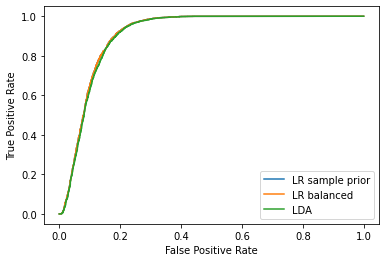

In [11]:
fig, ax = plt.subplots(1,1)

## <<< MODELS FROM BEFORE >>> (sampling methods ...)
#model = LogisticRegression( ).fit(X, Y)
#model_bal = LogisticRegression(class_weight='balanced').fit(X, Y)
#model_res = LogisticRegression( ).fit(X_res, Y_res)

model     = LinearDiscriminantAnalysis( ).fit(X, Y)
model_bal = LinearDiscriminantAnalysis(priors=[0.5, 0.5]).fit(X, Y)
model_res = LogisticRegression( ).fit(X, Y)

def display_roc_curve(ax, model, label=None):
    fpr, tpr, _ = sklearn.metrics.roc_curve(
        Ytest, model.decision_function(Xtest))
    sklearn.metrics.RocCurveDisplay(fpr=fpr, tpr=tpr).plot(
        ax, label=label)
    return sklearn.metrics.auc(fpr, tpr)

print(f"Naive: {display_roc_curve(ax, model,     'LR sample prior')}")
print(f"Balanced: {display_roc_curve(ax, model_bal, 'LR balanced')}")
print(f"LDA: {display_roc_curve(ax, model_res, 'LDA')}")

Why?
- ROC/AUC is classification-threshold-invariant. 
    - The measure depends on ranking, not on absolute values of the thresholds.


Control: 0.9064767199999999
Without Intercept: 0.6176675999999999
Random decision: 0.5014683999999999
Evil decision: 0.09637591999999999
Ideal decision: 1.0


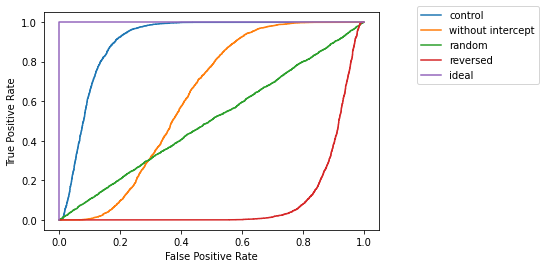

In [12]:
fig, ax = plt.subplots(1,1)

class MyRandomModel():
    def decision_function(self, X):
        return np.random.randn(X.shape[0])
    
class MyEvilModel(LogisticRegression):
    def decision_function(self, X):
        V = super().decision_function(X)
        return -V

class IdealModel():
    def decision_function(self, X):
        return Ytest
    

model_2 = LogisticRegression(fit_intercept=False).fit(X, Y)
model_3 = MyRandomModel()
model_4 = MyEvilModel().fit(X, Y)
model_5 = IdealModel()

print(f"Control: {display_roc_curve(ax, model, 'control')}")
print(f"Without Intercept: {display_roc_curve(ax, model_2, 'without intercept')}")
print(f"Random decision: {display_roc_curve(ax, model_3, 'random')}")
print(f"Evil decision: {display_roc_curve(ax, model_4, 'reversed')}")
print(f"Ideal decision: {display_roc_curve(ax, model_5, 'ideal')}")

ax.legend(bbox_to_anchor=(1.1, 1.05))

## Precision-Recall curve (PR-curve)


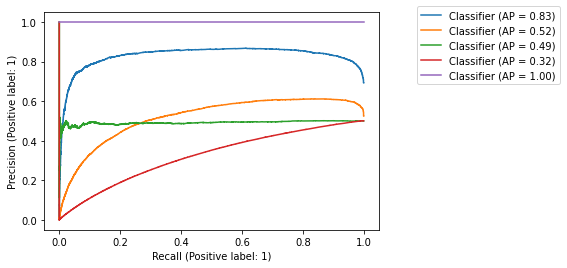

In [13]:
def display_pr_curve(ax, model, label=None):
    sklearn.metrics.PrecisionRecallDisplay.from_predictions(Ytest, model.decision_function(Xtest), ax=ax)

model     = LinearDiscriminantAnalysis( ).fit(X, Y)
model_2 = LogisticRegression(fit_intercept=False).fit(X, Y)

fig, ax = plt.subplots(1,1)

display_pr_curve(ax, model, 'control')
display_pr_curve(ax, model_2, 'without intercept')
display_pr_curve(ax, model_3, 'random')
display_pr_curve(ax, model_4, 'reversed')
display_pr_curve(ax, model_5, 'ideal')
ax.legend(bbox_to_anchor=(1.1, 1.05))

# Cost-Sensitive Learning
$$
\text{True Positive Rate} = \text{TPR} = \frac{TP}{TP + FN} = \frac{TP}{P}
$$

If the costs of misclassification are unequal, the optimal decision hyperline is likely different from equal cost classification. It is important to represent the cost of error/classification. Commonly, cost matrix is used.

$$ W(predicted, true) = \begin{pmatrix}  
    \text{cost of true negative} & \text{cost of false negative} \\ 
    \text{cost of false positive.} & \text{cost of true positive} 
\end{pmatrix} $$

(False negative == The classifier wrongly predicted the label to be positive)


## Theoretical Thresholding (Elkan 2001)
In (Elkan 2001) the theoretical threshold should be 
$$
t_{\text{theo}} = \frac{W(1,0) - W(0,0)}{sum(W)}.
$$

So in the case $W(predicted, true) = \begin{pmatrix} 0 & 2 \\ 1 & 0 \end{pmatrix}$,
the error is 
$$ 
t_{\text{theo}} = \frac{W(1,0) - W(0,0)}{sum(W)} = \frac{1 - 0}{sum(W)} = \frac{1}{3}
$$

Let's test that.



In [14]:
def binary_cls_thresholding(proba, threashold):
    return (proba[:, 1] > threashold).astype(int)

def calculate_cost(Ytrue, Ypred, cost_matrix):
    return np.mean(cost_matrix[Ytrue, Ypred])

def cost_threshold(model, threshold, cost_matrix):
    Ytest_proba = model.predict_proba(Xtest)
    Ypred = binary_cls_thresholding(Ytest_proba, threshold)
    return calculate_cost(Ytest, Ypred, cost_matrix)

cost_matrix = np.array([
    [0, 1],
    [2, 0]
])

model = QuadraticDiscriminantAnalysis(priors=[0.5, 0.5]).fit(X, Y)

print("Baseline (threshold 0.5):")
print(cost_threshold(model, 0.5, cost_matrix))
print()
print("Theoretical (threshold 1/3):")
print(cost_threshold(model, 1/3, cost_matrix))

Baseline (threshold 0.5):
0.1341

Theoretical (threshold 1/3):
0.1314


## Empirical thresholding (Sheng Ling 2006)
Select proper parameter based on the training data (exclusive search).

optimization: 0.394: 0.1285


Text(0, 0.5, 'cost')

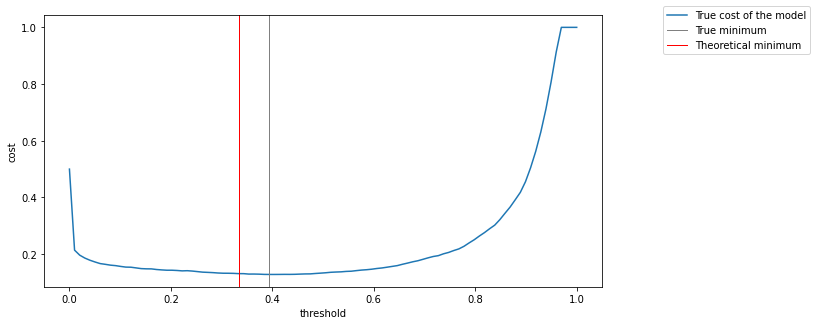

In [15]:
test_points = np.linspace(0, 1, 100)
cost = list(map(lambda x: cost_threshold(model, x, cost_matrix), test_points))
m = test_points[np.argmin(cost)]

fig, ax = plt.subplots(1,1, figsize=(10,5))

ax.plot(test_points, cost, label='True cost of the model')
ax.axvline(m, lw=1, c='grey', label='True minimum')
ax.axvline(1/3, lw=1, c='red', label='Theoretical minimum')
print(f'optimization: {m:.3}: {np.min(cost)}')
ax.legend()
ax.legend(bbox_to_anchor=(1.1, 1.05))
ax.set_xlabel('threshold')
ax.set_ylabel('cost')

## Transformation of the ROC curve 

FPR : 0.119, TPR: 0.901, threshold: 0.5927693446986595


Text(0, 0.5, 'relative cost')

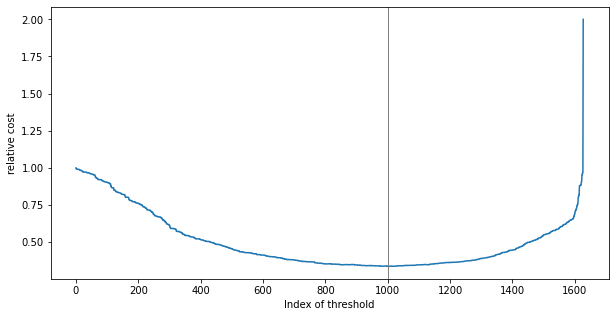

In [16]:
fpr, tpr, thr = sklearn.metrics.roc_curve(Ytest, model.decision_function(Xtest))
cost = fpr * cost_matrix[1,0] + (1 - tpr)*cost_matrix[0,1]
m = np.argmin(cost)

fig, ax = plt.subplots(1,1, figsize=(10,5))

ax.plot(np.arange(len(cost)), cost, label='True cost of the model')
ax.axvline(m, lw=1, c='grey')

print(f"FPR : {fpr[m]}, TPR: {tpr[m]}, threshold: {thr[m]}")

ax.set_xlabel('Index of threshold')
ax.set_ylabel('relative cost')

##  Models without probability output
- Just use sample or class weight (you need to train the model for every threshold)
- Save Time: Optimization of the weight 

In [17]:
if if # 

SyntaxError: invalid syntax (3998714723.py, line 1)

# Task

- [1b] Create a confusion matrix for LDA classifier trained on the modified digits dataset (X, Y)

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html#sklearn.metrics.ConfusionMatrixDisplay


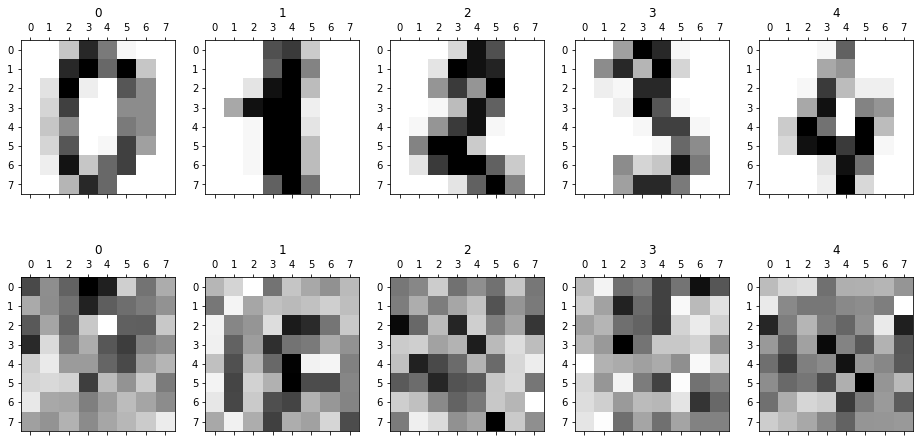

In [18]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

fig, axs = plt.subplots(2, 5, figsize=(16,8))
#plt.gray()

# DATASET:
X, Y = sklearn.datasets.load_digits(return_X_y=True)
X = X / 16

# display before additive noise
for i in range(5):
    axs[0,i].matshow(X[i].reshape(8,8), cmap='Greys')
    axs[0,i].set_title(str(Y[i]))

np.random.seed(0)
X = X + np.random.randn(*X.shape) + 0.5

# display after additive noise
for i in range(5):
    axs[1,i].matshow(X[i].reshape(8,8), cmap='Greys')
    axs[1,i].set_title(str(Y[i]))

In [ ]:
# TRAINING OF THE MODEL
model = LinearDiscriminantAnalysis()
# TODO: TRAIN the model

# TODO: DISPLAY Confusion Matrix

- [1b] What digits are most difficult for the estimator?
    - What combinations of
    - What is the ideal confusion matrix in this case [Help: [Counter(Y)[i] for i in range(10)]]

- [1b]

Imagine you are creating a classifier for a casino.
In the casino, the banknotes are scanned and exchanged to chips.
The managers told you to prefer mistakes of one type (client losing money) over another (casino losing money).

You decided that the digit 0 is 1.2 times more important to recognize than digit 1. 
In similar way, the 0 is $1.2^2$ times more important than 2.
And so on...

Using this preference create LDA model. 
Change only priors of classes to approximate the effect. 
Do not optimize the cost function nor use theoretical thresholding.

- [1b]

Create confusion matrix. What is the difference?

In [ ]:
priors = ??

model = LinearDiscriminantAnalysis(priors=priors)
model.fit(X, Y)

# Create Confusion Matrix